In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# !pip install --upgrade tensorflow==1.15.5
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or  Shift+Enter) will list all files under the input directory
# pressing
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/embedding/elmo_3/tfhub_module.pb
/kaggle/input/embedding-elmo/saved_model.pb
/kaggle/input/embedding-elmo/tfhub_module.pb
/kaggle/input/embedding-elmo/variables/variables.index
/kaggle/input/embedding-elmo/variables/variables.data-00000-of-00001
/kaggle/input/stanford-natural-language-inference-corpus/README.txt
/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_test.csv
/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_train.csv
/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_dev.csv
/kaggle/input/embedded-sentences-elmo/train_hypothesis_embedding.csv
/kaggle/input/embedded-sentences-elmo/train_premise_embedding.csv
/kaggle/input/embedded-sentences-elmo/test_hypothesis_embedding.csv
/kaggle/input/embedded-sentences-elmo/test_premise_embedding.csv


In [2]:
snli_train = pd.read_csv('/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_train.csv', nrows=300000)
snli_test = pd.read_csv('/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_test.csv')

In [3]:
print(snli_train['sentence1'][0],snli_train['sentence2'][0], snli_train['gold_label'][0])
print(snli_train['sentence1'][1],snli_train['sentence2'][1], snli_train['gold_label'][1])
print(snli_train['sentence1'][2],snli_train['sentence2'][2], snli_train['gold_label'][2])

A person on a horse jumps over a broken down airplane. A person is training his horse for a competition. neutral
A person on a horse jumps over a broken down airplane. A person is at a diner, ordering an omelette. contradiction
A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse. entailment


In [4]:
import numpy as np
# Filter and rename the important columns
train_df = snli_train.filter(['sentence1','sentence2','gold_label'], axis=1)
test_df = snli_test.filter(['sentence1','sentence2','gold_label'], axis=1)
train_df = train_df.rename(columns={"sentence1": "premise", "sentence2": "hypothesis"})
test_df = test_df.rename(columns={"sentence1": "premise", "sentence2": "hypothesis"})

# exclude sentences which could not be categorised
train_df = train_df[train_df['gold_label'] != "-"]
test_df = test_df[test_df['gold_label'] != "-"]

# exclude NaN values
train_df = train_df[train_df['hypothesis'] == train_df['hypothesis']]
test_df = test_df[test_df['hypothesis'] == test_df['hypothesis']]

train_df['gold_label'].value_counts()
print(train_df['premise'])

0         A person on a horse jumps over a broken down a...
1         A person on a horse jumps over a broken down a...
2         A person on a horse jumps over a broken down a...
3                     Children smiling and waving at camera
4                     Children smiling and waving at camera
                                ...                        
299995    Three young Asian ladies pose for a picture at...
299996    Three young Asian ladies pose for a picture at...
299997                         A woman in pain in her room.
299998                         A woman in pain in her room.
299999                         A woman in pain in her room.
Name: premise, Length: 299616, dtype: object


In [5]:
import tensorflow as tf
import transformers

max_length = 128  # Maximum length of input sentence to the model.
batch_size = 64
epochs = 40

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [7]:
train_df["label"] = train_df["gold_label"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

test_df["label"] = test_df["gold_label"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

In [8]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub

elmo = hub.load('../input/embedding-elmo')


2.3.1


In [9]:
import keras
from keras import backend as K
from keras.engine import Layer
import tensorflow_hub as hub
import tensorflow as tf

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
        self.dimensions = 1024
        self.trainable=True

    def build(self, input_shape):
        self.elmo = elmo
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo.signatures['default'](tf.squeeze(tf.cast(x, tf.string), axis=1))['default']
                    #  as_dict=True)
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [10]:
embed_batch_size = 100

def batch_embed(data, dataset):
    full_embed = elmo.signatures['default'](tf.cast(data[dataset][0:embed_batch_size], tf.string))['default']

    for i in range(len(data) // embed_batch_size):
        print(i * embed_batch_size)
        current = (i+1)*embed_batch_size
        tensor = tf.cast(data[dataset][current:current + embed_batch_size], tf.string)
        embed = elmo.signatures['default'](tensor)['default']
        full_embed = tf.concat([full_embed, embed], axis=0)

    print(full_embed)
    
    return full_embed

test_premise_embed = batch_embed(test_df, 'premise')
test_hypothesis_embed = batch_embed(test_df, 'hypothesis')


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
tf.Tensor(
[[-0.17454977  0.04414361  0.12465099 ... -0.23744154  0.16813906
  -0.03587628]
 [-0.17454977  0.04414361  0.12465099 ... -0.23744154  0.16813906
  -0.03587628]
 [-0.17454977  0.04414361  0.12465099 ... -0.23744154  0.16813906
  -0.03587628]
 ...
 [-0.21110037 -0.2673509  -0.05703427 ... -0.12372881  0.11923107
   0.09973644]
 [-0.21110037 -0.2673509  -0.05703427 ... -0.12372881  0.11923107
   0.09973644]
 [-0.21110037 -0.2673509  -0.05703427 ... -0.12372881  0.11923107
   0.09973644]], shape=(9824, 1024)

In [15]:
premise_embed = batch_embed(train_df, 'premise')
hypothesis_embed = batch_embed(train_df, 'hypothesis')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [16]:
import keras
from keras import datasets, layers, models

def create_elmo_model():
    # Encoded token ids from BERT tokenizer.
    premise = layers.Input(shape=(max_length,), dtype=tf.int32, name="premise")

    # Attention masks indicates to the model which tokens should be attended to.
    hypothesis = layers.Input(shape=(max_length,), dtype=tf.int32, name="hypothesis")
    # Token type ids are binary masks identifying different sequences in the model.
#     token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    
    conc=layers.concatenate([premise,hypothesis])
    y_1= tf.layers.Dense(300,activation='tanh')(conc)
    y_2= tf.layers.Dense(300,activation='tanh')(y_1)
    y_3= tf.layers.Dense(300,activation='tanh')(y_2)

    output=tf.layers.Flatten()(y_3)
    output = tf.layers.Dense(3, activation='softmax')(output)

    model = keras.models.Model([premise, hypothesis], output)
    model.summary()
    return model

def create_elmo_model2():
    premise = layers.Input(shape=(1024,), dtype="float")
    hypothesis = layers.Input(shape=(1024,), dtype="float")
    conc=layers.concatenate([premise,hypothesis])
    y_1= layers.Dense(300,activation='tanh')(conc)
    y_2= layers.Dense(300,activation='tanh')(y_1)
    y_3= layers.Dense(300,activation='tanh')(y_2)
    flat =layers.Flatten()(y_3)

    output = layers.Dense(3, activation='softmax')(flat)

    model = tf.keras.models.Model([premise, hypothesis], output)
    model.summary()
    return model
model = create_elmo_model2()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2048)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          614700      concatenate[0][0]     

In [17]:
model.compile(optimizer='Adadelta',loss='categorical_crossentropy',metrics = ['accuracy'])
history = model.fit([np.array(premise_embed), np.array(hypothesis_embed)],
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=1,
                    use_multiprocessing=True,
                    workers=-1)


Epoch 1/40
3746/3746 [==============================] - 12s 3ms/step - loss: 1.0555 - accuracy: 0.4457 - val_loss: 1.0108 - val_accuracy: 0.5070
Epoch 2/40
3746/3746 [==============================] - 12s 3ms/step - loss: 0.9843 - accuracy: 0.5303 - val_loss: 0.9620 - val_accuracy: 0.5443
Epoch 3/40
3746/3746 [==============================] - 13s 3ms/step - loss: 0.9466 - accuracy: 0.5548 - val_loss: 0.9332 - val_accuracy: 0.5620
Epoch 4/40
3746/3746 [==============================] - 12s 3ms/step - loss: 0.9232 - accuracy: 0.5692 - val_loss: 0.9144 - val_accuracy: 0.5742
Epoch 5/40
3746/3746 [==============================] - 12s 3ms/step - loss: 0.9072 - accuracy: 0.5792 - val_loss: 0.9013 - val_accuracy: 0.5825
Epoch 6/40
3746/3746 [==============================] - 12s 3ms/step - loss: 0.8956 - accuracy: 0.5869 - val_loss: 0.8916 - val_accuracy: 0.5882
Epoch 7/40
3746/3746 [==============================] - 12s 3ms/step - loss: 0.8867 - accuracy: 0.5922 - val_loss: 0.8840 - val_ac

77/77 [==============================] - 0s 2ms/step - loss: 0.8159 - accuracy: 0.6340
[0.8159200549125671, 0.6339576840400696]
tf.Tensor([2 1 0 ... 0 1 2], shape=(9824,), dtype=int64)
tf.Tensor([1 1 0 ... 0 1 2], shape=(9824,), dtype=int64)


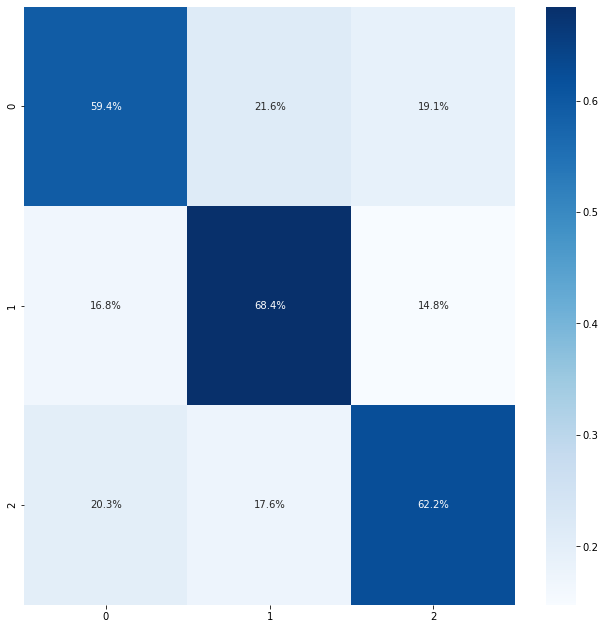

In [18]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

results = model.evaluate([test_premise_embed, test_hypothesis_embed], y_test, batch_size = 128)
print(results)

predictions = model.predict([test_premise_embed, test_hypothesis_embed])
print(tf.argmax(y_test, 1))
print(tf.argmax(predictions, 1))
cf_matrix = confusion_matrix(tf.argmax(y_test,1), tf.argmax(predictions,1), labels=[0,1,2])
cm_sum = np.sum(cf_matrix, axis=1, keepdims=True)
f = plt.figure(figsize=(11,11))
ax= plt.subplot()
sns.heatmap(cf_matrix/cm_sum, annot=True, ax=ax, fmt='0.1%', cmap='Blues') #annot=True to annotate cells

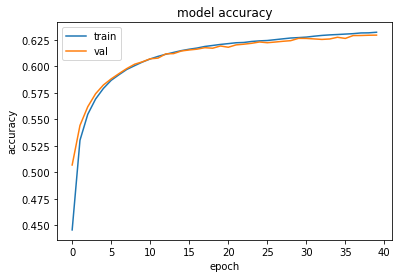

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [20]:
plt.savefig('Elmo_accuracy_300000_40epochs.png')

<Figure size 432x288 with 0 Axes>

In [21]:
model.save("Elmo_300000_40epochs.hdf5")

In [22]:
test_results_elmo = pd.DataFrame(predictions)
test_results_elmo.to_csv("Elmo_test_results_300000_40epochs.csv")

In [27]:
pd.DataFrame.from_dict(history.history).to_csv('history_300000_40epochs.csv',index=False)